# **Load Data and Saskatchewan RM Shapefile**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Axes: >

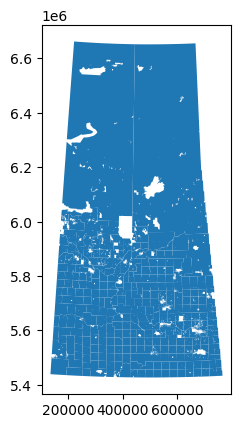

In [ ]:
# Mounting google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install mapclassify
!pip install mapclassify


# Importin Libraries
import pandas as pd # Data manipulation
import numpy as np # Matrix calculation
import geopandas as gpd # GIS of Pandas
import seaborn as sb # Parof of matplotlib for Data Viz
import matplotlib.pyplot as plt # data viz
from mapclassify import classify



# Defining Directories
directory_main = "/content/drive/MyDrive/PalleteSkills/"

#GIS
directory_gis= directory_main + 'SK_RM_Shapefiles/RuralMunicipality.shp'

# Yield
directory_rm_yields = directory_main + 'rm-yields-data.csv'

# Reading GIS
gdf_rm=gpd.read_file(directory_gis)

# Reading Yields
df_rm_yields=pd.read_csv(directory_rm_yields)

gdf_rm.plot()

## Exploratory Data Analysis

In [ ]:
df_rm_oats_n_barley_crops = df_rm_yields[['Year', 'RM','Oats','Barley']]
df_rm_oats_n_barley_crops
df_rm_oats_n_barley_crops.describe().T
df_rm_oats_n_barley_crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 0 to 25606
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    25607 non-null  int64  
 1   RM      25607 non-null  int64  
 2   Oats    24348 non-null  float64
 3   Barley  25272 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 800.3 KB


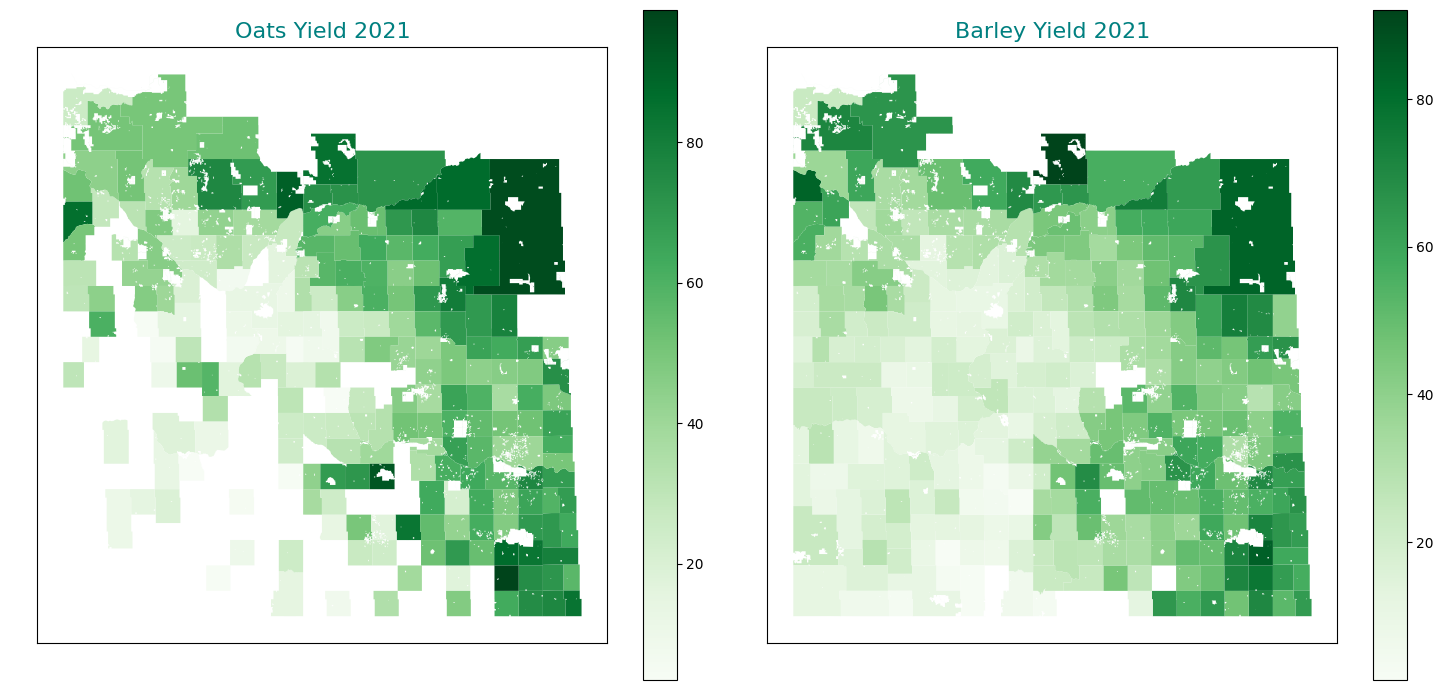

In [25]:
# Clean and prepare the GIS data
gdf_rm_clean = gdf_rm[['RMNO', 'RMNM', 'geometry']].copy()
# Need to change Object to Int
gdf_rm_clean['RMNO']=gdf_rm_clean['RMNO'].astype(int)
# Changin CRS system to regular lon and lat
gdf_rm_clean=gdf_rm_clean.to_crs(4326)

# Merging Yield data with GIS
gdf_rm_yield=pd.merge(gdf_rm_clean.rename(columns={'RMNO':'RM'}), df_rm_oats_n_barley_crops, on='RM', how='inner')

# looking at unique RM names for GIS data
gdf_rm_yield['RM'].unique().size


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot for Oats Yield 2021
gdf_rm_yield[gdf_rm_yield['Year']==2021].plot(
    column='Oats',
    cmap='Greens',
    legend=True,
    ax=axs[0]
)
axs[0].set_title('Oats Yield 2021', color='teal', size=16)
axs[0].tick_params(colors='white')

# Plot for Barley Yield 2021
gdf_rm_yield[gdf_rm_yield['Year']==2021].plot(
    column='Barley',
    cmap='Greens',
    legend=True,
    ax=axs[1]
)
axs[1].set_title('Barley Yield 2021', color='teal', size=16)
axs[1].tick_params(colors='white')

plt.tight_layout()
plt.savefig('oats_barley_2021_Production.png')  # Save the plot as a PNG file
plt.show()


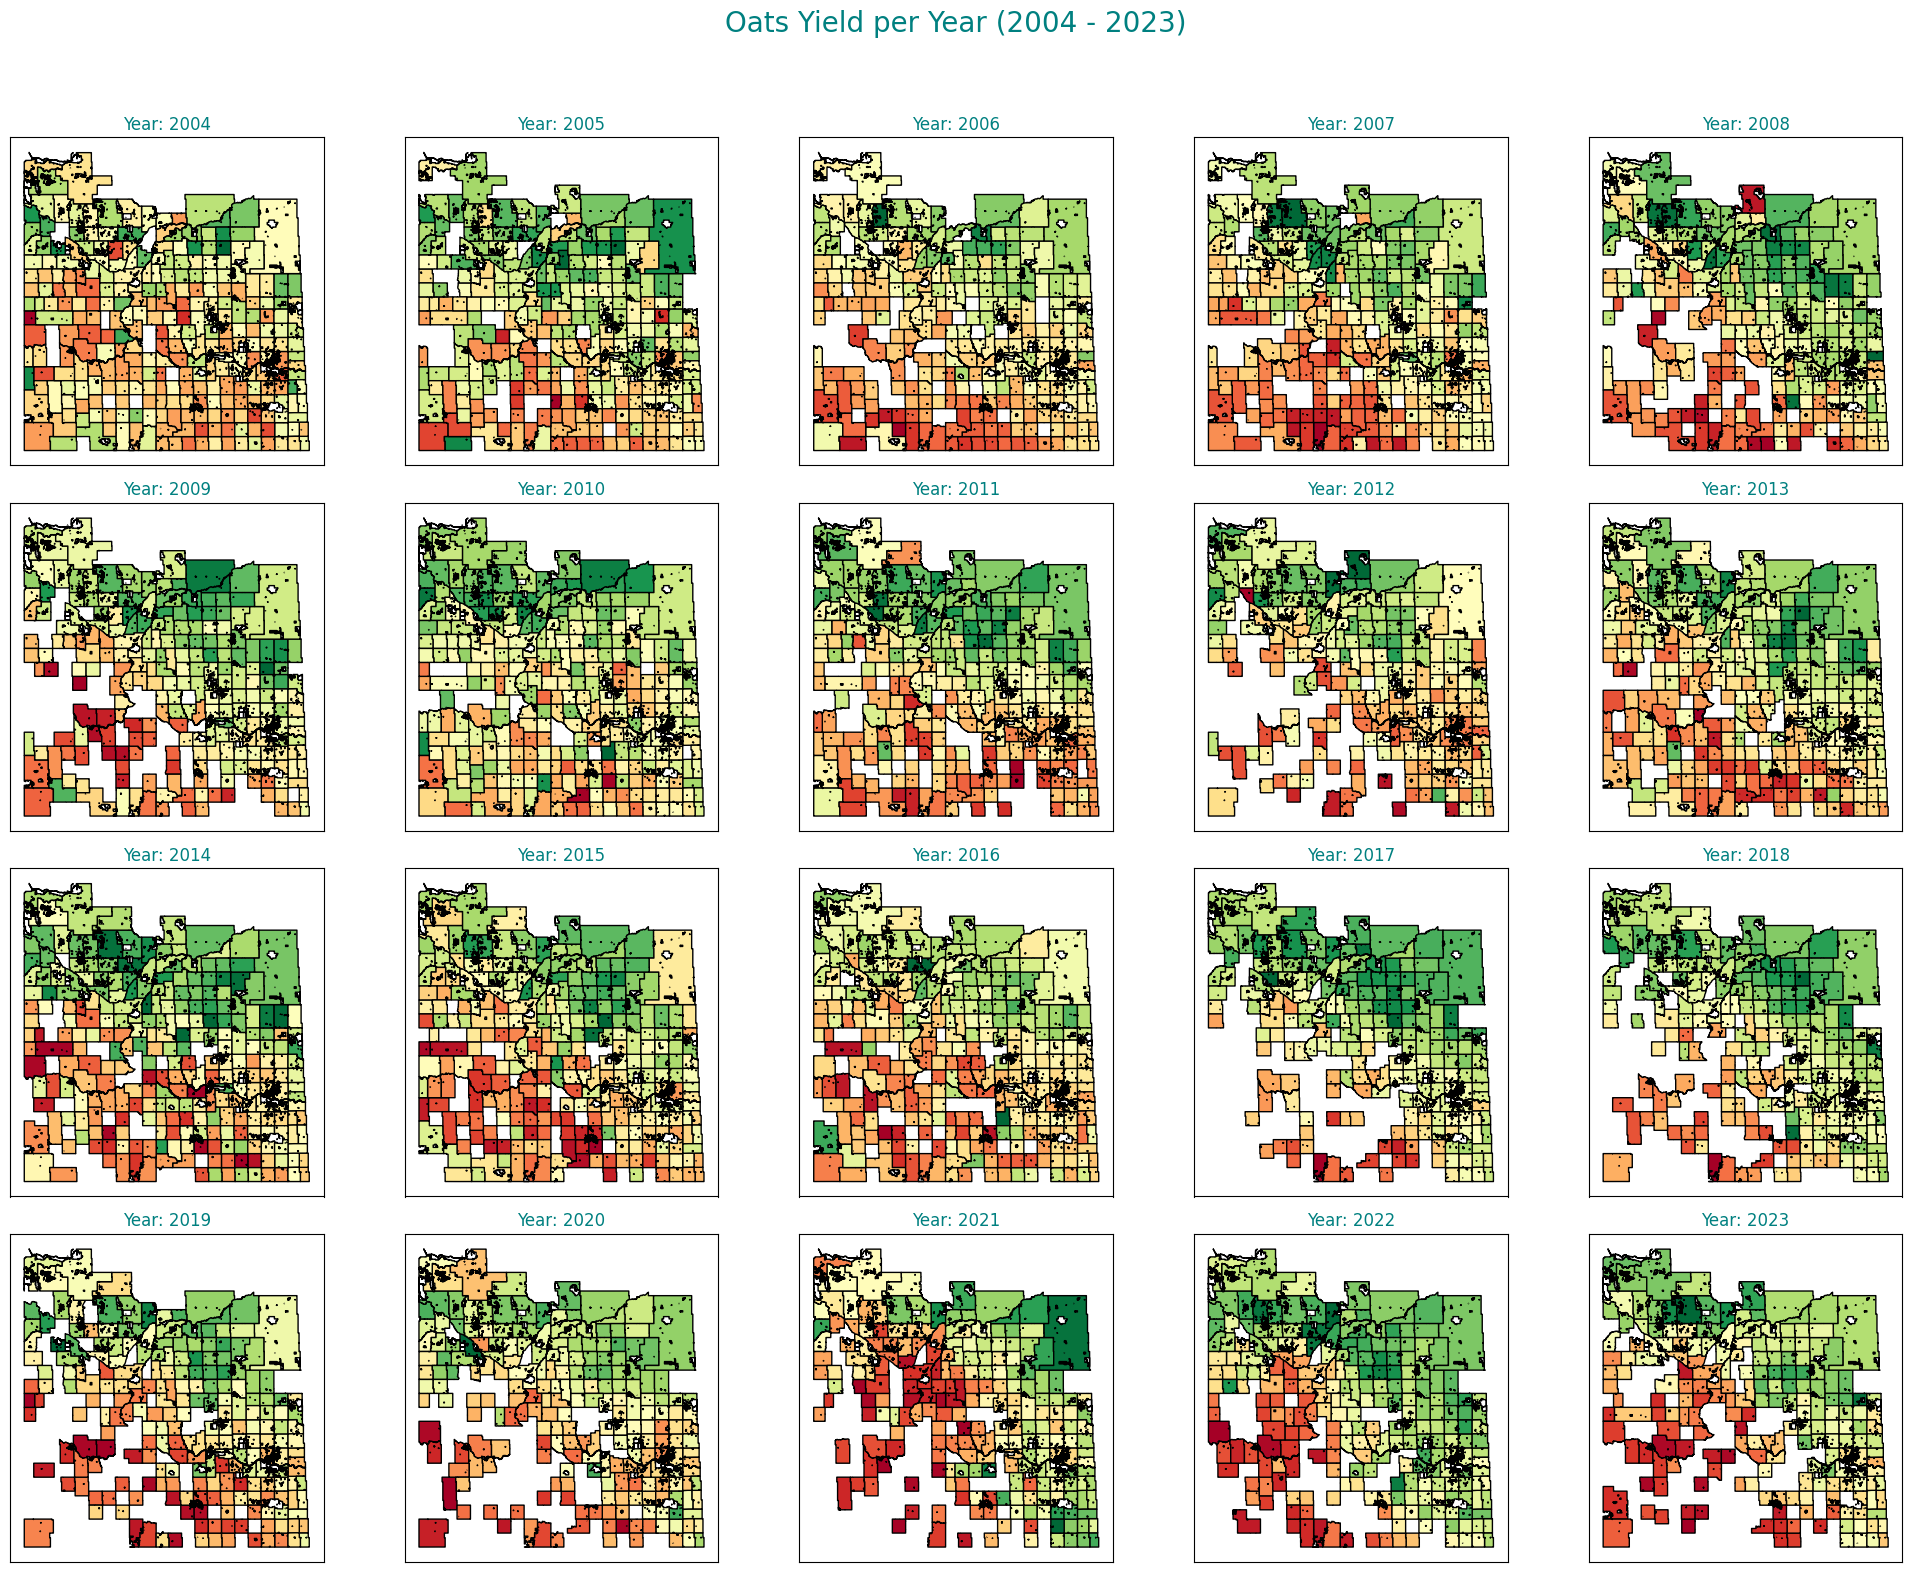

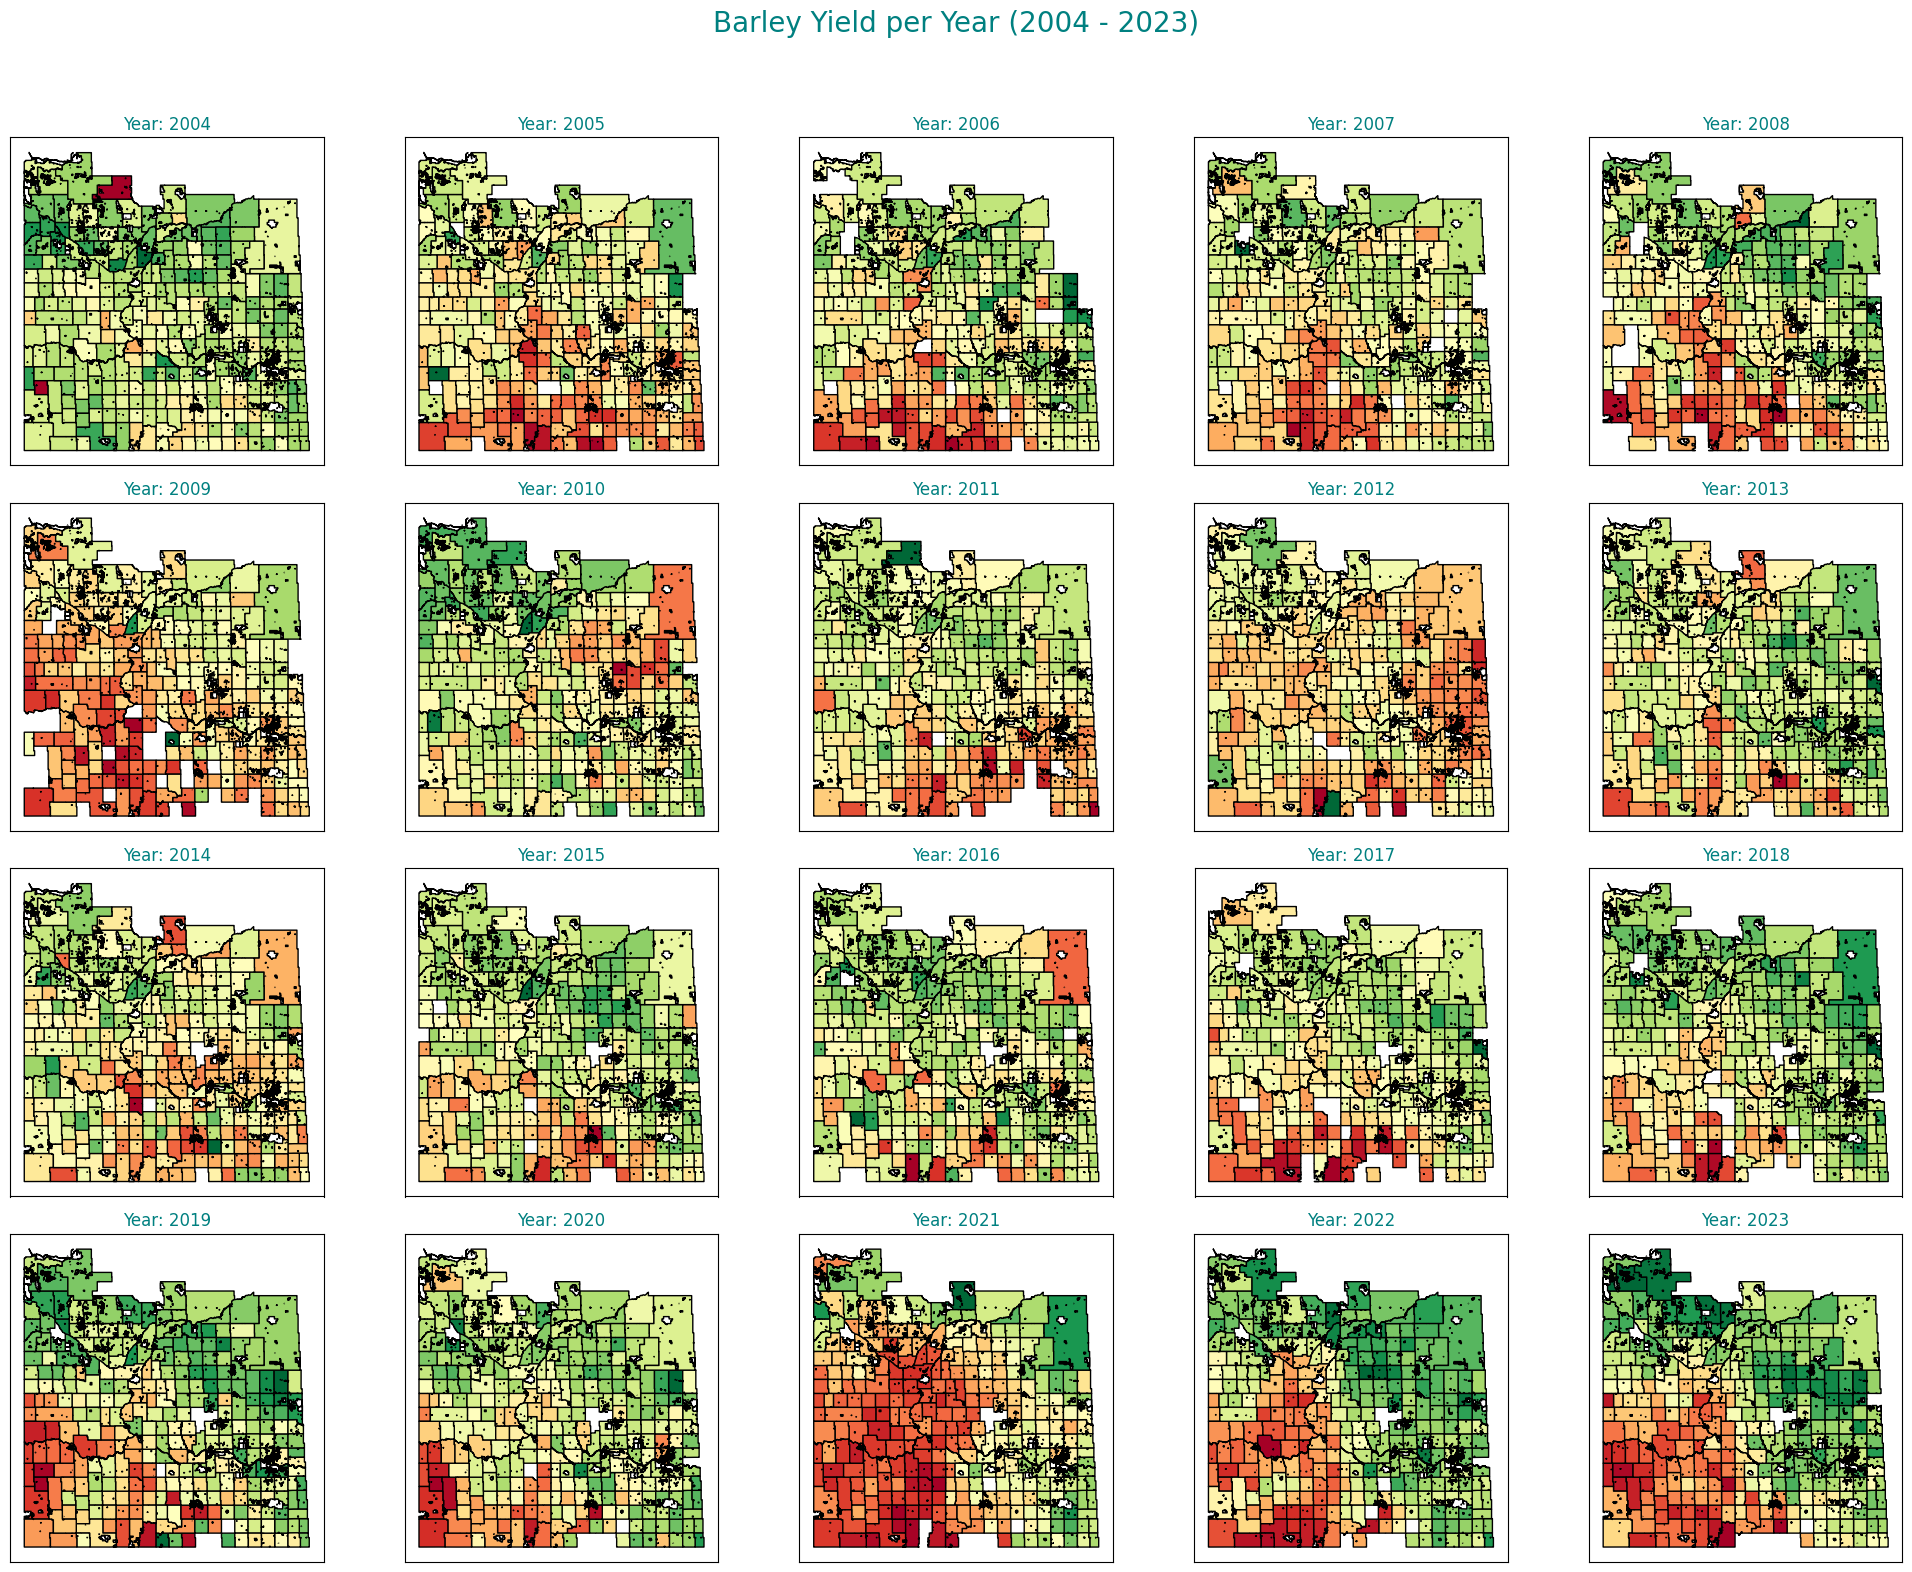

In [ ]:
# List of crops to include in plots
crops = ['Oats', 'Barley']

# List of years to include in subplots
years = list(range(2004, 2023 + 1))

# Function to plot yield data for a specific crop
def plot_yield_by_year(crop):
    # Set up the figure with 4 rows and 5 columns for the 20 subplots
    fig, axs = plt.subplots(4, 5, figsize=(20, 16))
    fig.suptitle(f'{crop} Yield per Year (2004 - 2023)', color='teal', size=20)

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    # Loop through each year and plot it on its respective subplot
    for i, year in enumerate(years):
        ax = axs[i]
        gdf_rm_yield[gdf_rm_yield['Year'] == year].plot(
            column=crop,
            cmap='RdYlGn',
            legend=False,
            ax=ax,
            edgecolor='black'
        )
        ax.set_title(f'Year: {year}', color='teal', size=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Adjust the spacing between subplots for readability
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Generate plots for each crop
for crop in crops:
    plot_yield_by_year(crop)

<Axes: >

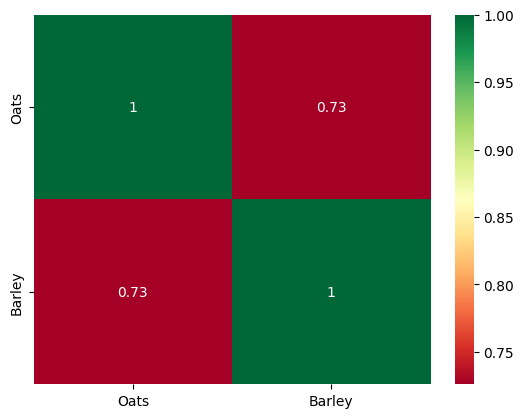

In [ ]:
# crops - is a list defined in mapping cell
# >0.2 slight correlation
# >0.4 Moderate corrleation
# > 0.6 High
# > 0.8 Very correlation

# Pearson Correlation
sb.heatmap(df_rm_oats_n_barley_crops.loc[df_rm_oats_n_barley_crops['Year']>2003][crops].corr(),
           annot=True,
           cmap='RdYlGn')

# Rank correlatation

## Outliers

 **Before treating**

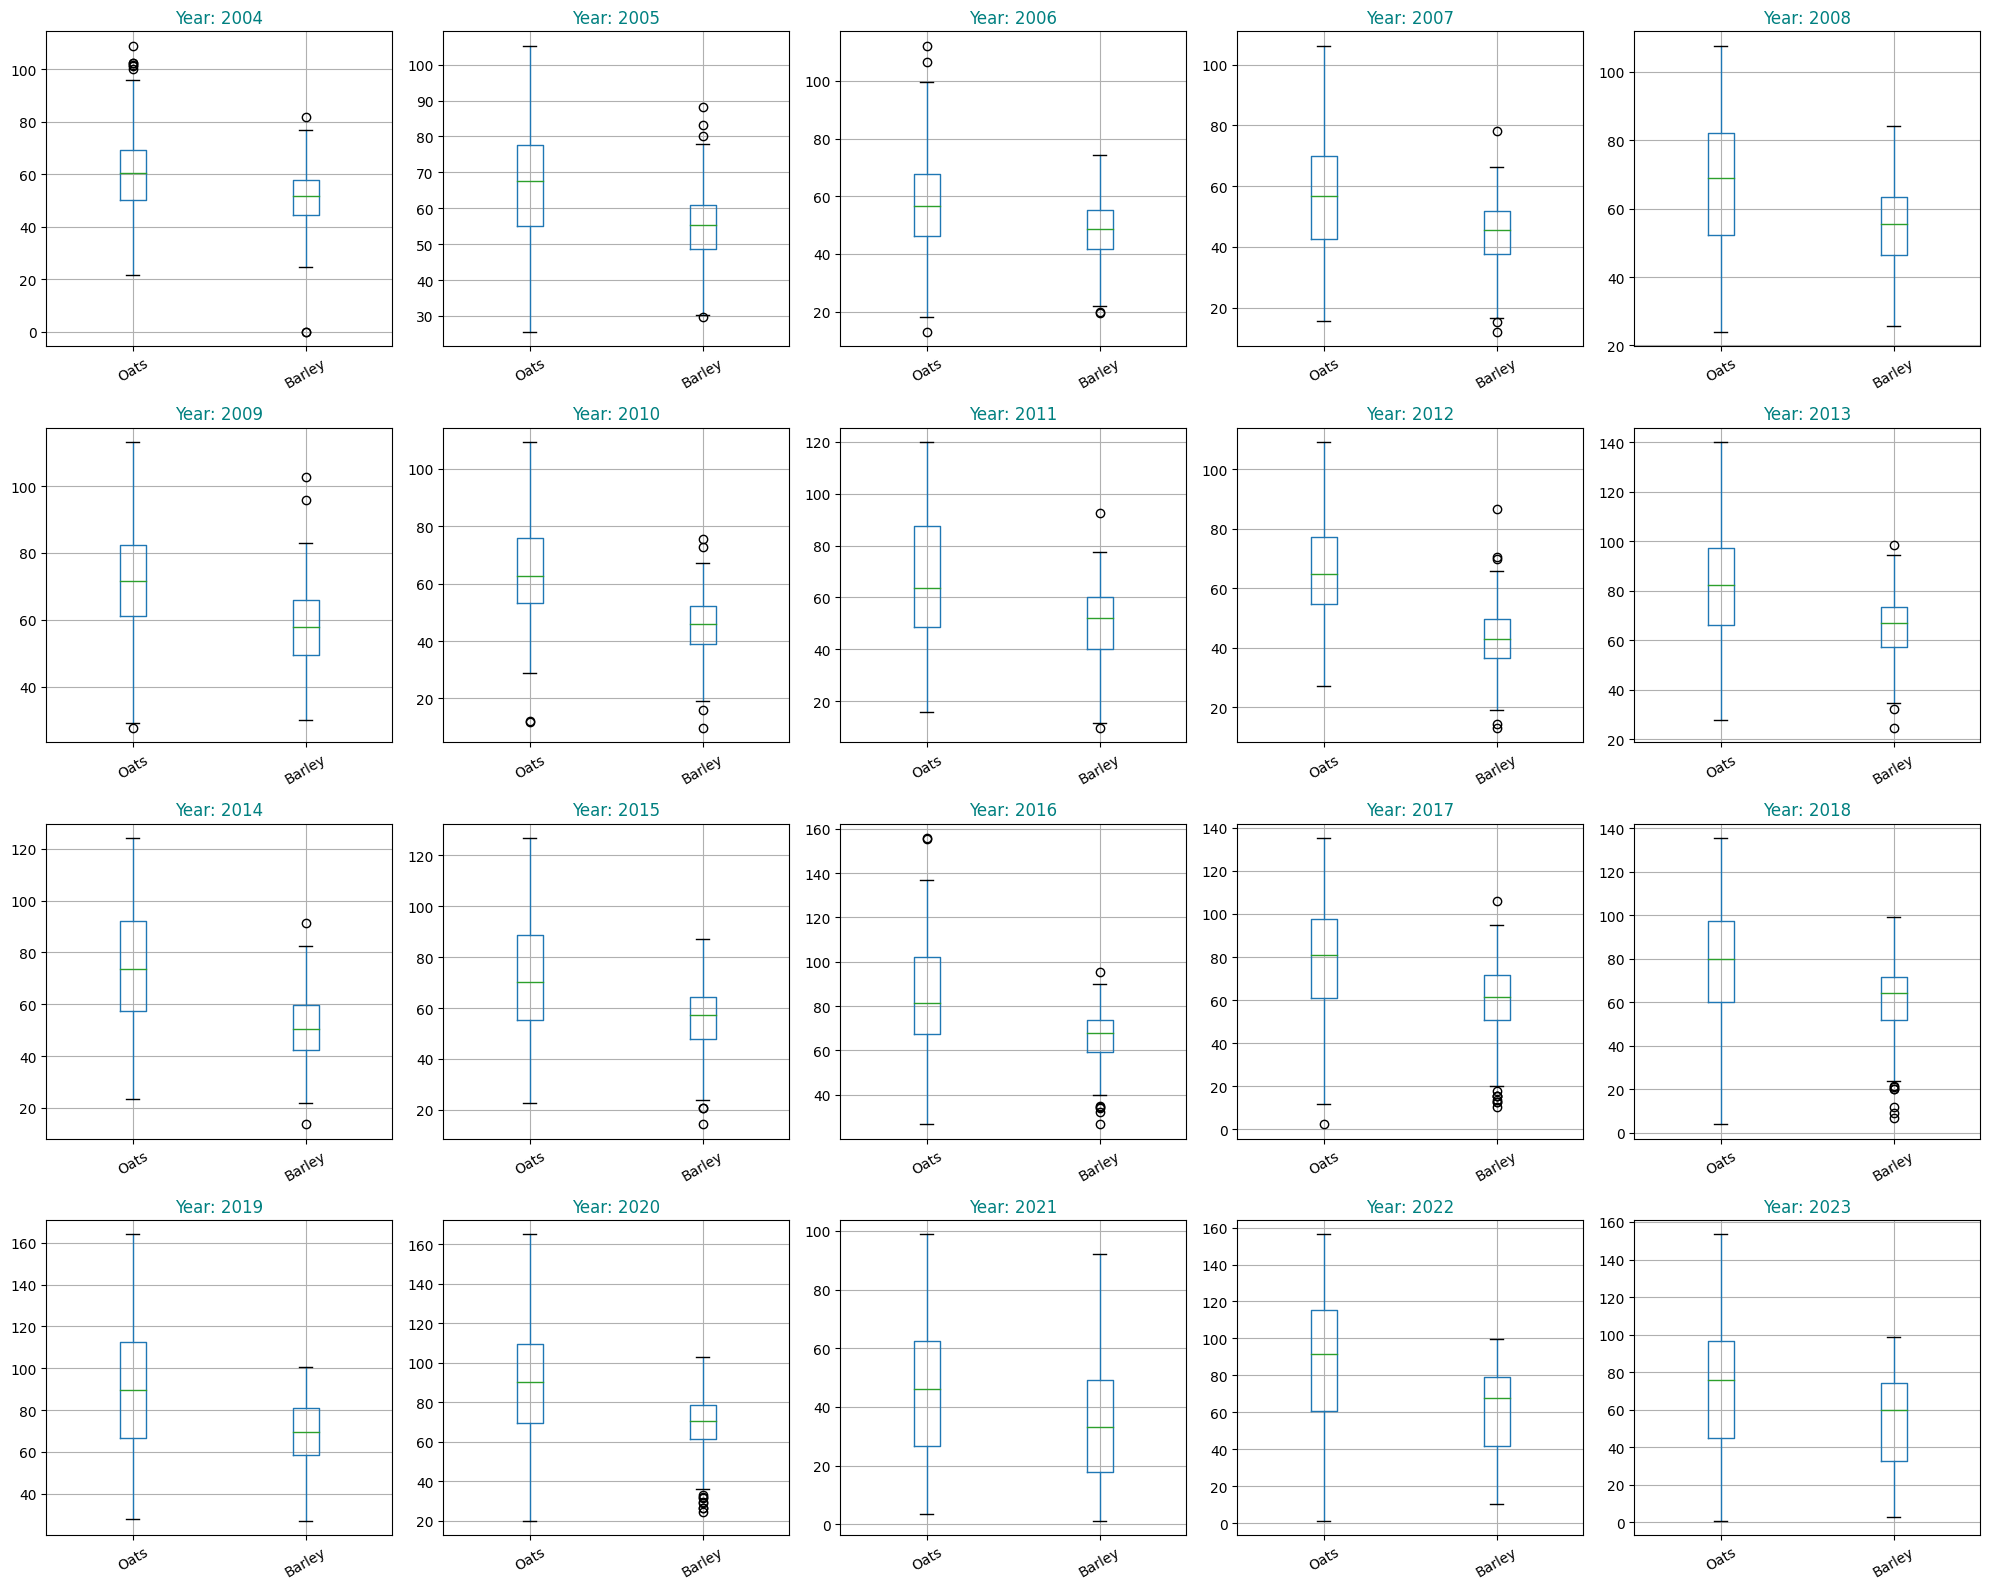

In [18]:
# Filter the DataFrame for the years 2004-2023
filtered_df = df_rm_oats_n_barley_crops[(df_rm_oats_n_barley_crops['Year'] >= 2004) & (df_rm_oats_n_barley_crops['Year'] <= 2023)]

# Define the list of crops
crops = ['Oats','Barley']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the years and create a boxplot for each crop
for i, year in enumerate(range(2004, 2023 + 1)):
    if i < len(axes):
        ax = axes[i]
        year_data = filtered_df[filtered_df['Year'] == year]
        year_data.boxplot(column=crops, ax=ax)
        ax.set_title(f'Year: {year}', size=12, color='teal')
        ax.tick_params(axis='x', rotation=30)  # Rotate x-tick labels

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('oats_barley_outlier_Before_Treating.png')  # Save the plot as a PNG file
plt.show()

**After treating**

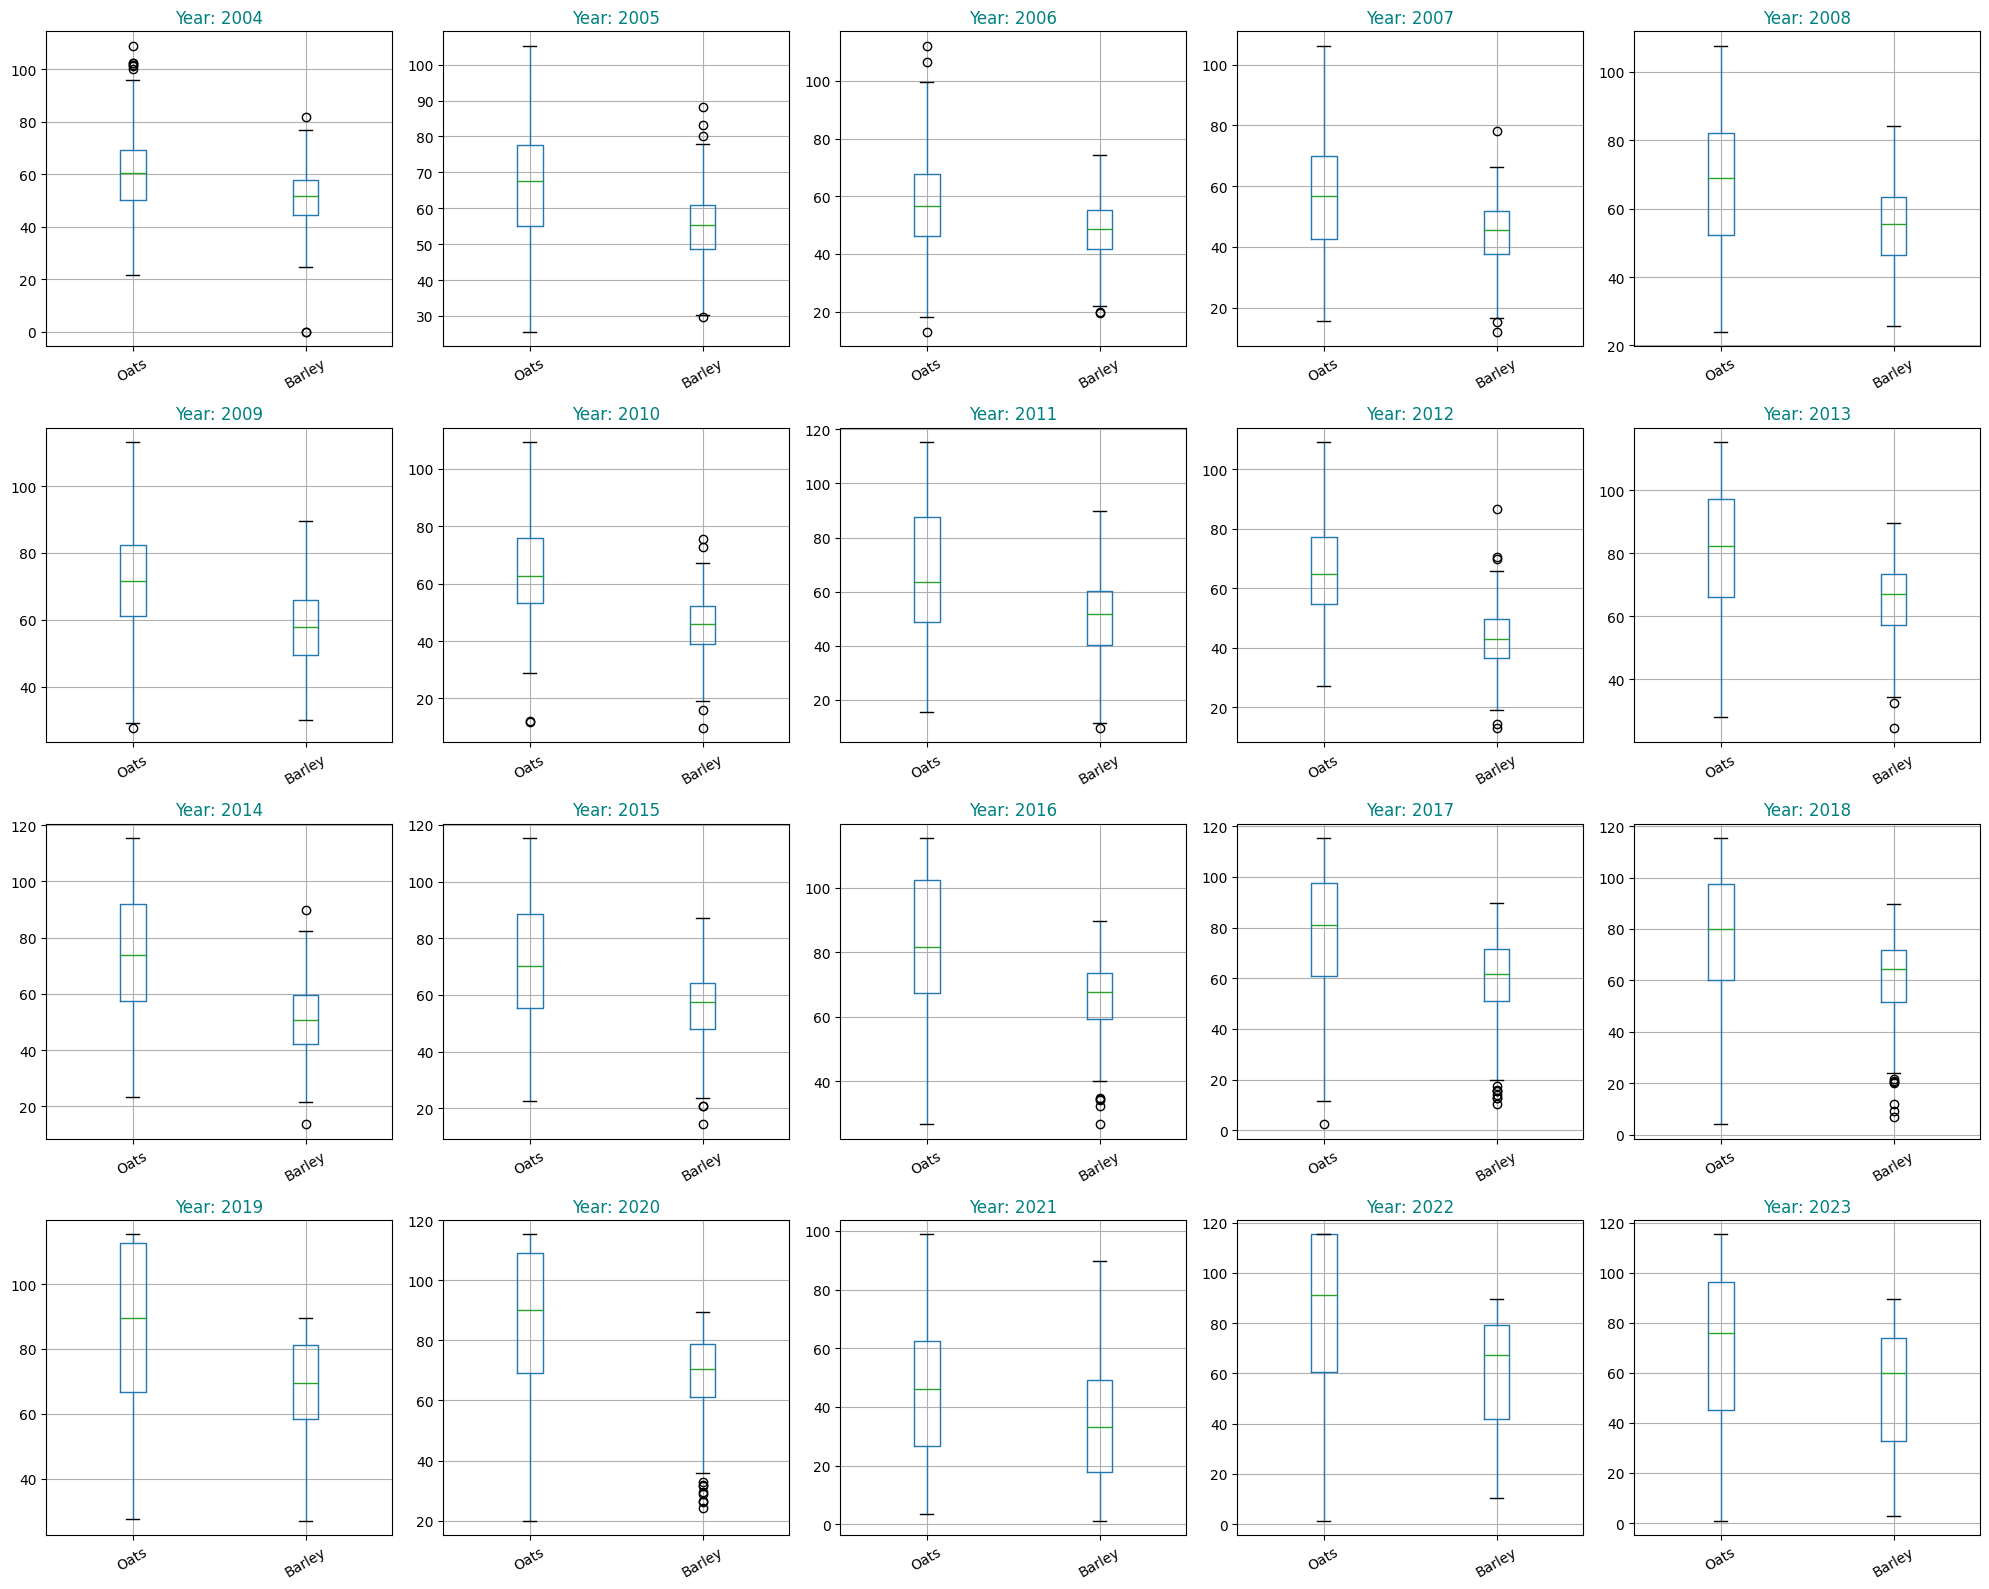

In [33]:
# Define the list of crops
crops = ['Oats','Barley']

# Calculate mean and standard deviation for each crop
means = df_rm_oats_n_barley_crops[crops].mean()
stds = df_rm_oats_n_barley_crops[crops].std()

# Determine the clipping bounds
lower_bounds = means - 3 * stds
upper_bounds = means + 3 * stds

# Clip the data
df_clipped = df_rm_oats_n_barley_crops.copy()
for crop in crops:
    df_clipped[crop] = df_rm_oats_n_barley_crops[crop].clip(lower=lower_bounds[crop], upper=upper_bounds[crop])



# Define the list of crops
#crops = ['Canola', 'Spring Wheat', 'Durum', 'Oats', 'Lentils', 'Peas', 'Barley']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the years and create a boxplot for each crop
for i, year in enumerate(range(2004, 2023 + 1)):
    if i < len(axes):
        ax = axes[i]
        year_data = df_clipped[df_clipped['Year'] == year]
        year_data.boxplot(column=crops, ax=ax)
        ax.set_title(f'Year: {year}', size=12, color='teal')
        ax.tick_params(axis='x', rotation=30)  # Rotate x-tick labels

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('oats_barley_outlier_After_Treating.png')  # Save the plot as a PNG file
plt.show()

## Feature Constructions and Selection

### Historical Avg

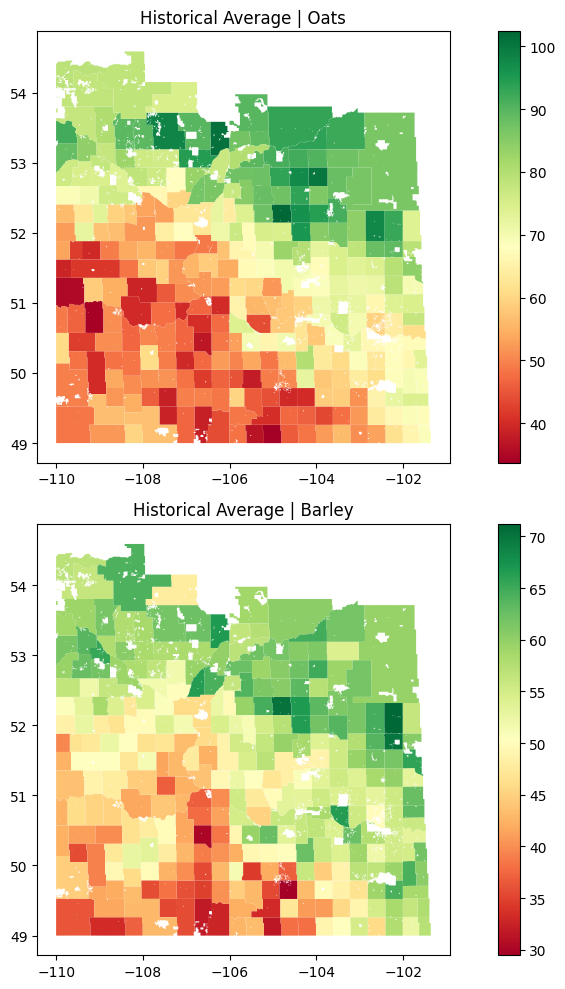

In [ ]:
# We will filter years from 2000-2023

#df_00_23=df_major_crops[df_major_crops['Year']>=2000].drop(columns='decade')
df_00_23=df_rm_oats_n_barley_crops[df_rm_oats_n_barley_crops['Year']>=2000]


merged_df = pd.merge(
    gdf_rm_clean.rename(columns={'RMNO': 'RM'}),
    df_00_23.groupby('RM').mean(),
    on='RM'
)

# List of crops
crops = ['Oats','Barley']

# Create a subplot for each crop
fig, axes = plt.subplots(nrows=len(crops), figsize=(10, 5 * len(crops)))

# Plot each crop
for i, crop in enumerate(crops):
    merged_df.plot(column=crop, cmap='RdYlGn', legend=True, ax=axes[i])
    axes[i].set_title(f'Historical Average | {crop}')

plt.tight_layout()
plt.show()

In [ ]:
# List of crops
crops = ['Oats', 'Barley']

# Group by 'RM' and calculate mean and standard deviation for each crop
df_agg_00_23 = df_00_23.groupby('RM')[crops].agg(['mean', 'std'])

# Flatten the column multi-index
df_agg_00_23.columns = ['_'.join(col).strip() for col in df_agg_00_23.columns.values]

# Reset index to make 'RM' a column again
df_agg_00_23.reset_index(inplace=True)

## Clustering

Optimal number of clusters for Oats: 2
Silhouette scores for Oats: [0.48611858215870757, 0.35962638353376186, 0.3952967598647857, 0.3601939538593756, 0.38096086207313024, 0.38597319583252204, 0.36843567332397814, 0.37262712455779173, 0.3697114126420209]


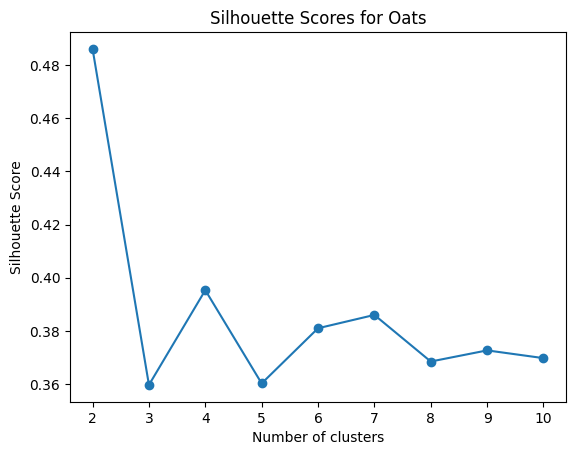

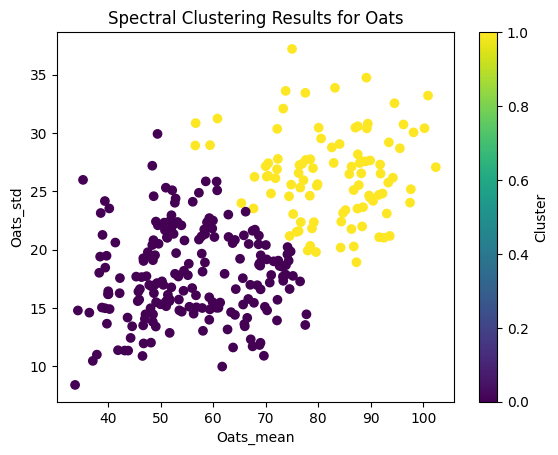

Optimal number of clusters for Barley: 2
Silhouette scores for Barley: [0.3670150384861933, 0.3348533092557515, 0.35587068730107074, 0.33419606793807277, 0.349010098057453, 0.35693409598836556, 0.323058637873144, 0.3233099176198432, 0.34235735762646646]


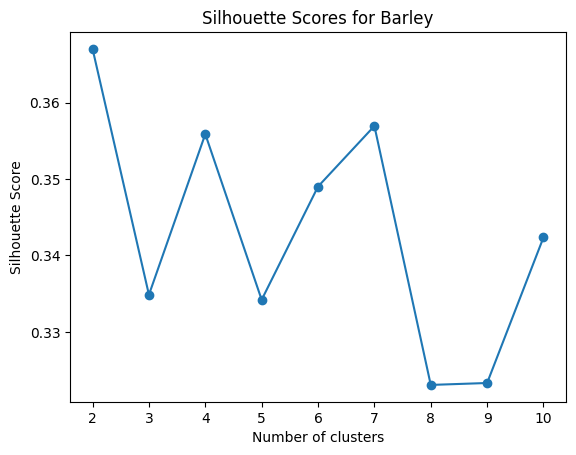

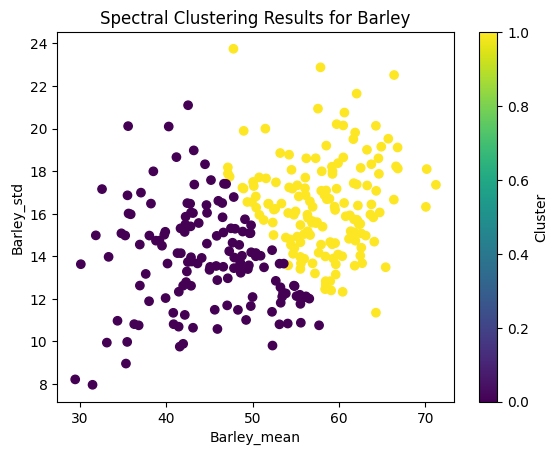

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df_agg_00_23 is already loaded
crops = ['Oats', 'Barley']

# Function to prepare data for each crop
def prepare_data_for_crop(df, crop):
    columns = [f'{crop}_mean', f'{crop}_std']
    crop_data = df[columns].dropna().values
    return crop_data

# Standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

# Function to perform spectral clustering and choose the optimal number of clusters
def spectral_clustering(data, n_clusters):
    clustering = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=0)
    labels = clustering.fit_predict(data)
    return labels

# Function to find the optimal number of clusters
def find_optimal_clusters(data, max_k):
    scores = []
    for k in range(2, max_k+1):
        labels = spectral_clustering(data, k)
        score = silhouette_score(data, labels)
        scores.append(score)
    optimal_k = scores.index(max(scores)) + 2
    return optimal_k, scores

# Iterate over each crop and perform clustering
for crop in crops:
    # Prepare the data for the crop
    crop_data = prepare_data_for_crop(df_agg_00_23, crop)

    # Standardize the data
    crop_data_scaled = standardize_data(crop_data)

    # Find the optimal number of clusters
    optimal_k, scores = find_optimal_clusters(crop_data_scaled, 10)

    # Perform spectral clustering with the optimal number of clusters
    labels = spectral_clustering(crop_data_scaled, optimal_k)

    # Add the cluster labels to the original dataframe
    df_agg_00_23[f'{crop}_Cluster'] = np.nan
    df_agg_00_23.loc[~df_agg_00_23[[f'{crop}_mean', f'{crop}_std']].isna().any(axis=1), f'{crop}_Cluster'] = labels

    # Print the results
    print(f'Optimal number of clusters for {crop}: {optimal_k}')
    print(f'Silhouette scores for {crop}: {scores}')

    # Visualize the silhouette scores
    plt.plot(range(2, 11), scores, marker='o')
    plt.title(f'Silhouette Scores for {crop}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Visualize the clustering results
    plt.scatter(df_agg_00_23[f'{crop}_mean'], df_agg_00_23[f'{crop}_std'], c=df_agg_00_23[f'{crop}_Cluster'], cmap='viridis')
    plt.title(f'Spectral Clustering Results for {crop}')
    plt.xlabel(f'{crop}_mean')
    plt.ylabel(f'{crop}_std')
    plt.colorbar(label='Cluster')
    plt.show()

### Customized Clusters

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

# Assuming df_agg_00_23 is already loaded
crops = ['Oats', 'Barley']

# Function to prepare data for each crop
def prepare_data_for_crop(df, crop):
    columns = [f'{crop}_mean', f'{crop}_std']
    crop_data = df[columns].dropna().values
    return crop_data, df[columns].dropna().index

# Standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

# Perform spectral clustering with a fixed number of clusters
def perform_spectral_clustering(data, n_clusters=5):
    clustering = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=0)
    labels = clustering.fit_predict(data)
    return labels

# Iterate over each crop and perform clustering
for crop in crops:
    # Prepare the data for the crop
    crop_data, indices = prepare_data_for_crop(df_agg_00_23, crop)

    # Standardize the data
    crop_data_scaled = standardize_data(crop_data)

    # Perform spectral clustering with 5 clusters
    labels = perform_spectral_clustering(crop_data_scaled, 5)

    # Add the cluster labels to the original dataframe
    df_agg_00_23[f'{crop}_Cluster_Spectral'] = np.nan
    df_agg_00_23.loc[indices, f'{crop}_Cluster_Spectral'] = labels

# Display the dataframe with the new cluster columns
df_agg_00_23

pd.merge(gdf_rm_clean.rename(columns={'RMNO':'RM'}),
         df_agg_00_23,
          on='RM' )\
            .explore('Oats_Cluster_Spectral',
                     cmap='RdYlGn',
                     scheme='naturalbreaks',
                     k=5)

## Historical Crops labeled by clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


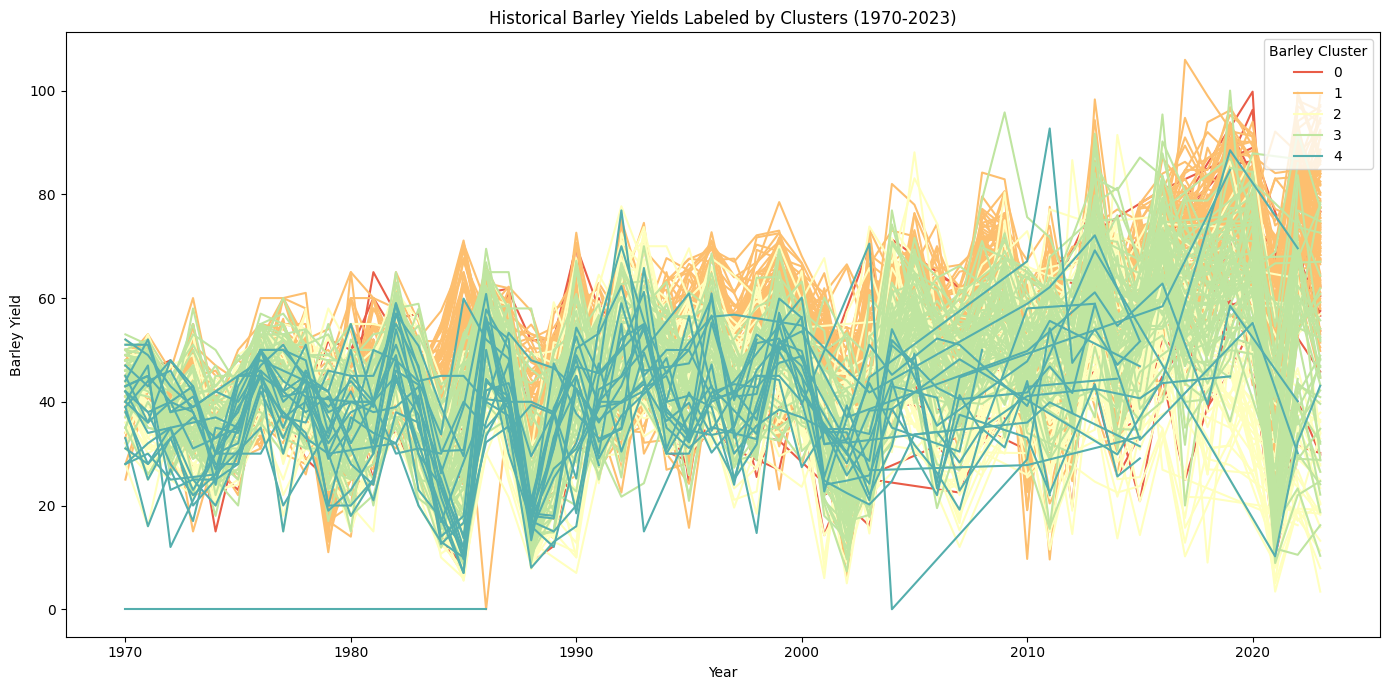

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Define the crop type to plot: 'Canola', 'Barley', or 'Oats'
crop_type = 'Barley'  # Change this to 'Barley' or 'Oats' as needed

# Load the data
df_1970_23 = df_rm_oats_n_barley_crops[df_rm_oats_n_barley_crops['Year'] >= 1970]

df_00_23 = pd.DataFrame(df_1970_23)

# Ensure the data is clean
df_00_23 = df_00_23.dropna()

# Aggregate the data by RM and Year to find the mean yield for the selected crop
df_agg = df_00_23.groupby(['RM', 'Year']).agg({crop_type: 'mean'}).reset_index()

# Pivot the data to have Years as columns and RMs as rows
df_pivot = df_agg.pivot(index='RM', columns='Year', values=crop_type).fillna(0)

# Perform KMeans clustering on the pivoted data
kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

# Merge the cluster labels back to the original data
df_agg = df_agg.merge(df_pivot[['Cluster']], on='RM')

# Define a custom color palette
palette = sns.color_palette("Spectral", n_colors=5)

# Plot using seaborn and matplotlib
plt.figure(figsize=(14, 7))

# Create the line plot
sns.lineplot(x='Year', y=crop_type, hue='Cluster', data=df_agg, palette=palette, linewidth=1.5, estimator=None, units='RM')

# Add titles and labels
plt.title(f'Historical {crop_type} Yields Labeled by Clusters (1970-2023)')
plt.xlabel('Year')
plt.ylabel(f'{crop_type} Yield')
plt.legend(title=f'{crop_type} Cluster', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


## Bubble Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


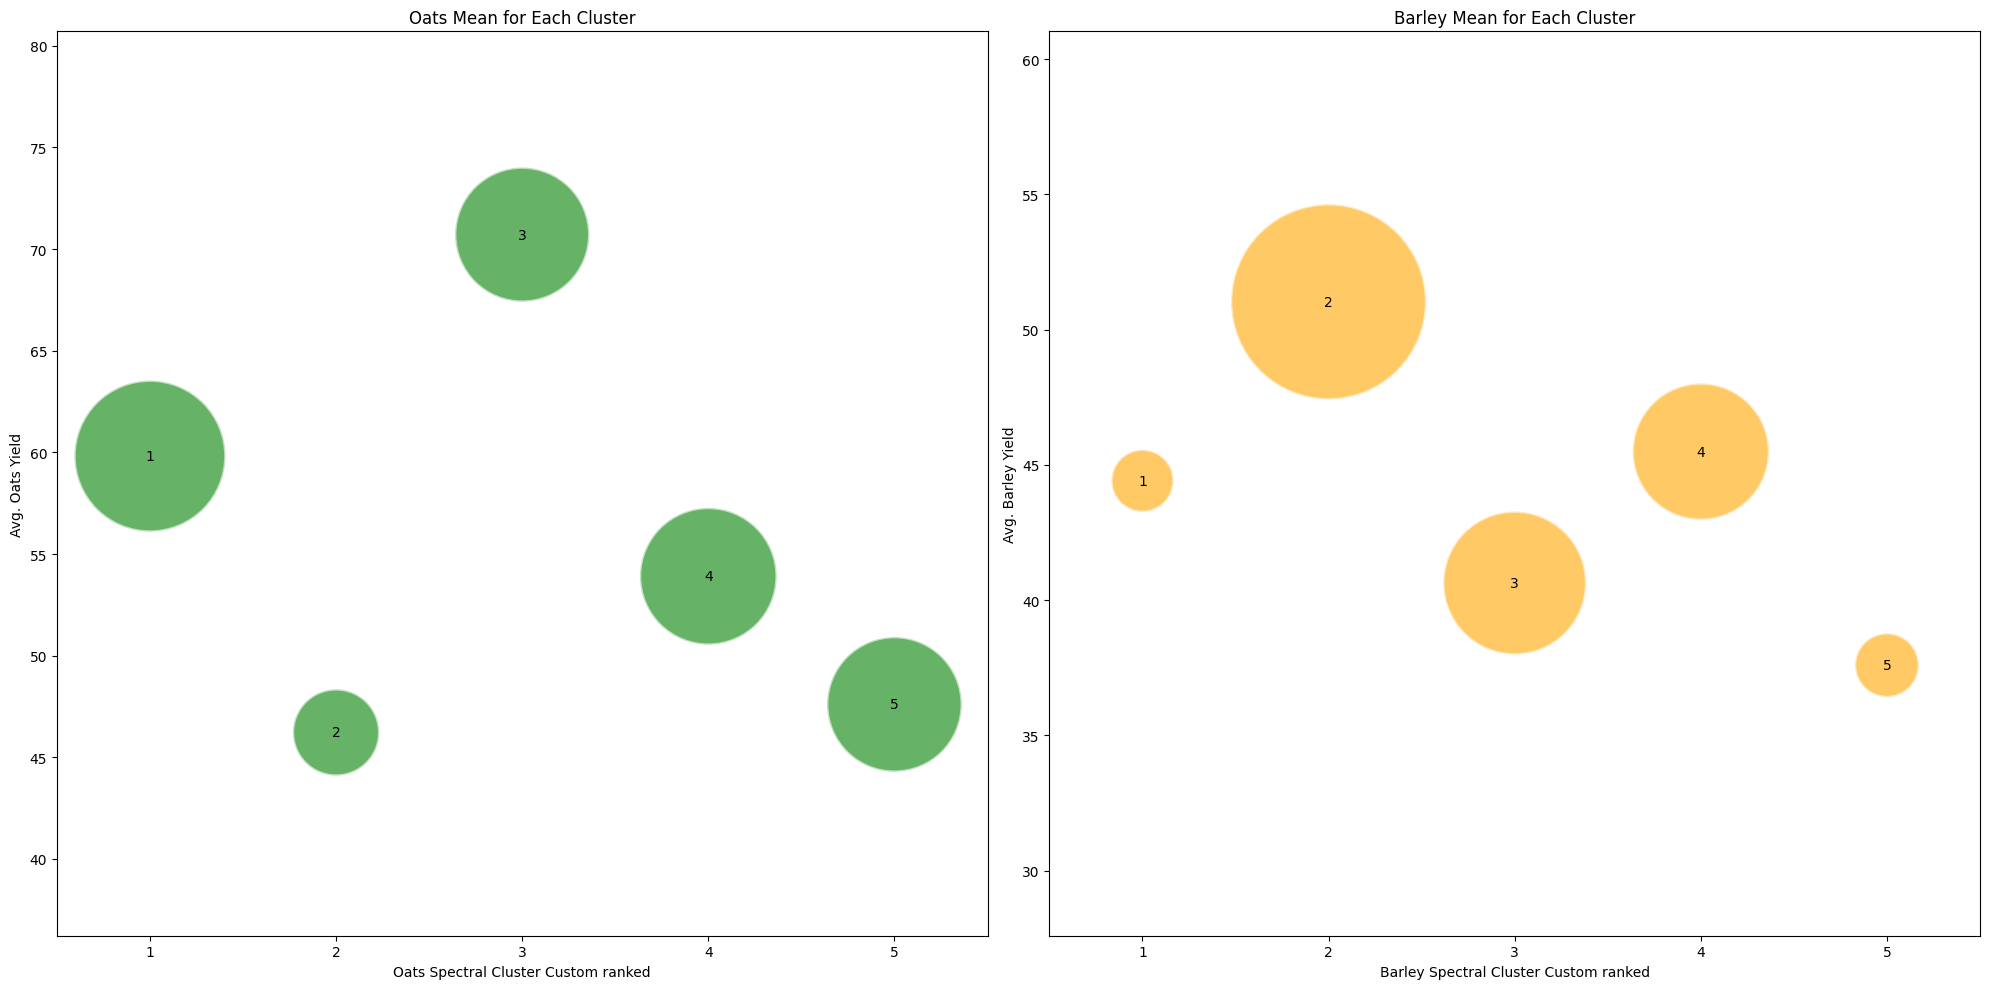

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_bubble_cluster(crop_type, ax):
    # Load the data
    df_1970_23 = df_rm_oats_n_barley_crops[df_rm_oats_n_barley_crops['Year'] >= 1970]

    df_00_23 = pd.DataFrame(df_1970_23)

    # Ensure the data is clean
    df_00_23 = df_00_23.dropna()

    # Aggregate the data by RM and Year to find the mean yield for the selected crop
    df_agg = df_00_23.groupby(['RM', 'Year']).agg({crop_type: 'mean'}).reset_index()

    # Pivot the data to have Years as columns and RMs as rows
    df_pivot = df_agg.pivot(index='RM', columns='Year', values=crop_type).fillna(0)

    # Perform KMeans clustering on the pivoted data
    kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
    df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

    # Merge the cluster labels back to the original data
    df_agg = df_agg.merge(df_pivot[['Cluster']], on='RM')

    # Calculate the mean yield for each cluster
    df_cluster_stats = df_agg.groupby('Cluster').agg({crop_type: ['mean', 'size']}).reset_index()
    df_cluster_stats.columns = ['Cluster', f'Avg_{crop_type}_Yield', 'Count']

    # Create the bubble plot
    bubble_sizes = df_cluster_stats['Count'] * 3  # Adjust the multiplier to change bubble size

    ax.scatter(
        x=df_cluster_stats['Cluster'] + 1,  # Offset clusters for clarity
        y=df_cluster_stats[f'Avg_{crop_type}_Yield'],
        s=bubble_sizes,  # Bubble size
        alpha=0.6,
        color="green" if crop_type == 'Oats' else "orange",
        edgecolors="w",
        linewidth=2
    )

    # Add titles and labels
    ax.set_title(f'{crop_type} Mean for Each Cluster')
    ax.set_xlabel(f'{crop_type} Spectral Cluster Custom ranked')
    ax.set_ylabel(f'Avg. {crop_type} Yield')

    # Adjust axis limits to prevent bubbles from being cut off
    ax.set_xlim(0.5, df_cluster_stats['Cluster'].max() + 1.5)
    ax.set_ylim(df_cluster_stats[f'Avg_{crop_type}_Yield'].min() - 10, df_cluster_stats[f'Avg_{crop_type}_Yield'].max() + 10)

    # Add annotations for each bubble
    for i in range(df_cluster_stats.shape[0]):
        ax.text(
            df_cluster_stats['Cluster'][i] + 1,
            df_cluster_stats[f'Avg_{crop_type}_Yield'][i],
            f"{int(df_cluster_stats['Cluster'][i]) + 1:.0f}",
            ha='center',
            va='center',
            fontsize=10,
            color='black'
        )

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Oats
plot_bubble_cluster('Oats', axs[0])

# Plot for Barley
plot_bubble_cluster('Barley', axs[1])

plt.tight_layout()
plt.show()


## Historical crops labeled by clusters together

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


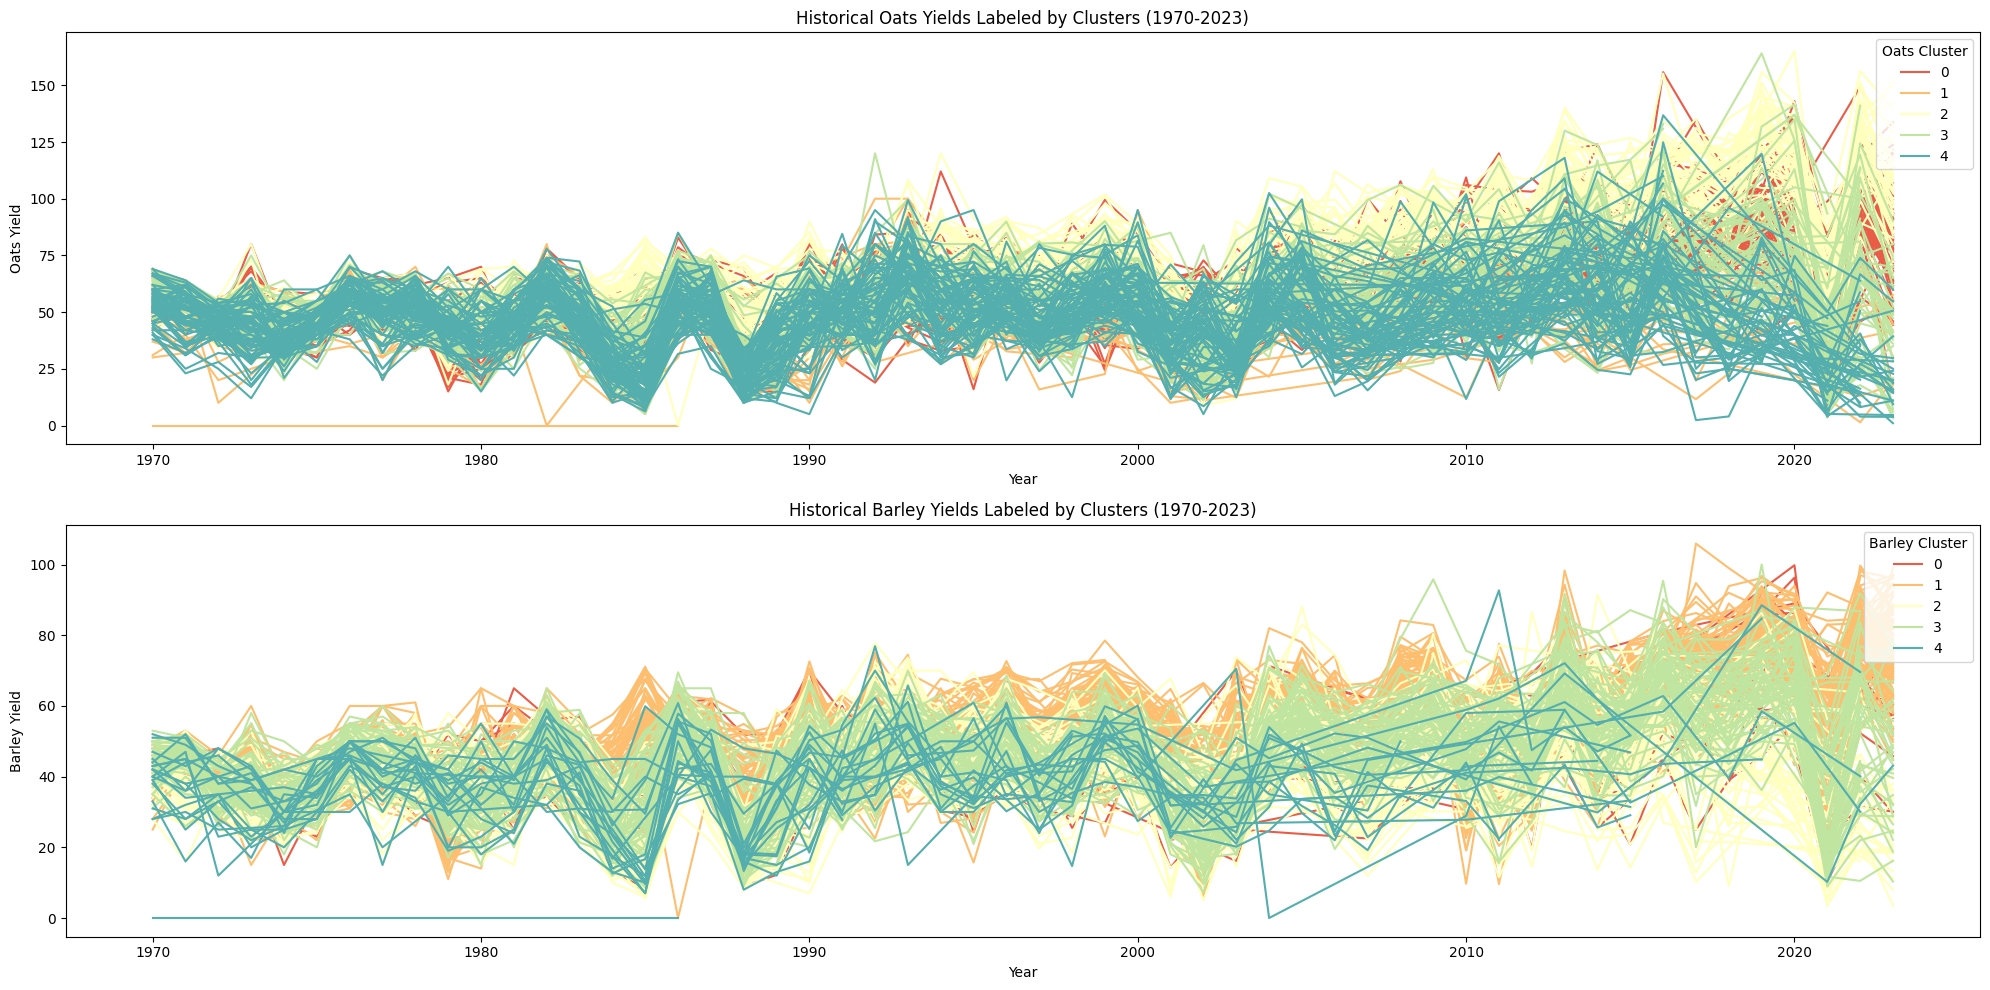

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Function to plot the line plot for a given crop type
def plot_clustered_yields(crop_type, ax):
    # Load the data
    df_1970_23 = df_rm_oats_n_barley_crops[df_rm_oats_n_barley_crops['Year'] >= 1970]

    df_00_23 = pd.DataFrame(df_1970_23)

    # Ensure the data is clean
    df_00_23 = df_00_23.dropna()

    # Aggregate the data by RM and Year to find the mean yield for the selected crop
    df_agg = df_00_23.groupby(['RM', 'Year']).agg({crop_type: 'mean'}).reset_index()

    # Pivot the data to have Years as columns and RMs as rows
    df_pivot = df_agg.pivot(index='RM', columns='Year', values=crop_type).fillna(0)

    # Perform KMeans clustering on the pivoted data
    kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
    df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

    # Merge the cluster labels back to the original data
    df_agg = df_agg.merge(df_pivot[['Cluster']], on='RM')

    # Define a custom color palette
    palette = sns.color_palette("Spectral", n_colors=5)

    # Create the line plot
    sns.lineplot(x='Year', y=crop_type, hue='Cluster', data=df_agg, palette=palette, linewidth=1.5, estimator=None, units='RM', ax=ax)

    # Add titles and labels
    ax.set_title(f'Historical {crop_type} Yields Labeled by Clusters (1970-2023)')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'{crop_type} Yield')
    ax.legend(title=f'{crop_type} Cluster', loc='upper right')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Plot for Oats
plot_clustered_yields('Oats', axs[0])

# Plot for Barley
plot_clustered_yields('Barley', axs[1])

plt.tight_layout()
plt.show()
